In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [ ]:
df = pd.read_csv('data.csv', parse_dates=[3])

## Processing data

In [ ]:
df.iloc[30:40]

,Artist,Album,Song,Date
30,The Smiths,Louder Than Bombs,Girl Afraid - 2011 Remaster,2019-06-07 14:37:00
31,The Smiths,Meat Is Murder,What She Said - 2011 Remaster,2019-06-07 04:51:00
32,Anarbor,Anarbor,Already Dead,2019-06-06 12:48:00
33,Melanie Martinez,Gingerbread Man,Gingerbread Man,2019-06-06 12:47:00
34,The 1975,I Like It When You Sleep For You Are So Beauti...,Love Me,2019-06-06 12:46:00
35,The All-American Rejects,When the World Comes Down,Gives You Hell,2019-06-06 12:45:00
36,Rafael Lechowski & Glaç,Donde duele inspira (2007-2011),36500 días,2019-06-06 06:16:00
37,Mitski,Be the Cowboy,Nobody,2019-06-06 03:48:00
38,Videoclub,Amour Plastique,Amour Plastique,2019-06-06 03:14:00
39,Julieta Venegas,Si,Lento,2019-06-06 02:27:00


In [ ]:
df_filtered = df[df.groupby(['Artist'])['Song'].transform(lambda x : x.count()>100)]

In [ ]:
df_filtered['month'] = df_filtered.Date.dt.to_period('M').values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_filtered.head(10)

,Artist,Album,Song,Date,month
0,Bayside,Acoustic,Masterpiece,2019-06-08 06:20:00,2019-06
1,Bayside,Acoustic,Paternal Reversal,2019-06-08 06:17:00,2019-06
2,Bayside,Acoustic,Montauk,2019-06-08 06:13:00,2019-06
3,Bayside,The Walking Wounded (Gold Edition),Choice Hops and Bottled Self Esteem,2019-06-07 22:59:00,2019-06
4,Bayside,Vacancy,The Ghost,2019-06-07 22:40:00,2019-06
5,Bayside,Killing Time,Mona Lisa,2019-06-07 22:24:00,2019-06
6,Bayside,Bayside,Devotion and Desire,2019-06-07 22:20:00,2019-06
7,Bayside,Vacancy,Rumspringa (Return To Heartbreak Road),2019-06-07 22:17:00,2019-06
8,Bayside,Acoustic Volume 2,Duality,2019-06-07 22:13:00,2019-06
9,Bayside,Acoustic Volume 2,Duality,2019-06-07 21:32:00,2019-06


In [ ]:
df_months = df_filtered.groupby(['Artist', 'month']).Song.count().reset_index()
df_months.sample(5)

,Artist,month,Song
5021,Vance Joy,2017-05,2
3296,Pentatonix,2016-11,3
566,Bayside,2018-09,145
4147,System of a Down,2016-02,2
4104,Superlitio,2016-12,13


In [ ]:
df_final = df_months.set_index(['month', 'Artist']).unstack(fill_value=0).asfreq('M', fill_value=0).stack().sort_index(level=1).reset_index()
df_final.loc[130:140]

,month,Artist,Song
130,2015-08,Adam Lambert,1
131,2015-09,Adam Lambert,32
132,2015-10,Adam Lambert,25
133,2015-11,Adam Lambert,20
134,2015-12,Adam Lambert,9
135,2016-01,Adam Lambert,2
136,2016-02,Adam Lambert,18
137,2016-03,Adam Lambert,4
138,2016-04,Adam Lambert,6
139,2016-05,Adam Lambert,6


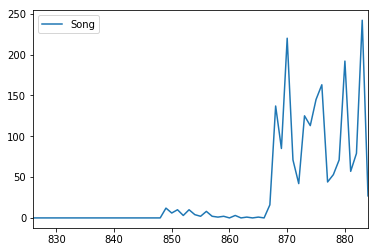

In [ ]:
df_final[df_final.Artist=='Bayside'].plot()

In [ ]:
data = []
for artist_name, df_g in df_final.groupby('Artist'):
  data.append(df_g.Song.values)
data = np.array(data)

In [ ]:
data.shape

(144, 59)

In [ ]:
# First months used for training
months_train = 48
# Months used for prediction
window_len = 12

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(data.shape[0]):
  for j in range(window_len, data.shape[1]):
    x_obs = data[i][j-window_len:j]
    y_obs = data[i][j]
    if np.sum(x_obs)<=5: continue
    if j>=months_train:
      X_test.append(x_obs)
      y_test.append(y_obs)
    else:
      X_train.append(x_obs)
      y_train.append(y_obs)
      
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], window_len, 1))
X_test = X_test.reshape((X_test.shape[0], window_len, 1))

In [ ]:
X_train.shape, X_test.shape

((4332, 12, 1), (1439, 12, 1))

## Model

In [ ]:
from keras.layers import LSTM, Dense, Input, Dropout
from keras.models import Model


def create_model(input_shape):
  model_input = Input(input_shape)
  X = LSTM(16, activation='relu')(model_input)
  X = Dropout(0)(X)
  X = Dense(1)(X)
  return Model(inputs=model_input, outputs=X)

In [ ]:
model = create_model((window_len,1))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 12, 1)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras.backend as K

def custom_loss(y_true, y_pred):
  return K.mean(K.abs((y_true - y_pred)/(y_true+1))) * 100

model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle=True, validation_data=(X_test, y_test))

Train on 4332 samples, validate on 1439 samples
Epoch 1/30
4332/4332 [==============================] - 6s 1ms/step - loss: 7.0038 - val_loss: 4.4926
Epoch 2/30
4332/4332 [==============================] - 3s 689us/step - loss: 5.2490 - val_loss: 4.2624
Epoch 3/30
4332/4332 [==============================] - 3s 695us/step - loss: 4.9535 - val_loss: 4.1766
Epoch 4/30
4332/4332 [==============================] - 3s 702us/step - loss: 4.8074 - val_loss: 4.0492
Epoch 5/30
4332/4332 [==============================] - 3s 697us/step - loss: 4.7338 - val_loss: 4.0187
Epoch 6/30
4332/4332 [==============================] - 3s 691us/step - loss: 4.6548 - val_loss: 4.0501
Epoch 7/30
4332/4332 [==============================] - 3s 692us/step - loss: 4.7267 - val_loss: 4.0405
Epoch 8/30
4332/4332 [==============================] - 3s 688us/step - loss: 4.6262 - val_loss: 4.0307
Epoch 9/30
4332/4332 [==============================] - 3s 695us/step - loss: 4.5997 - val_loss: 4.0414
Epoch 10/30
4332/4

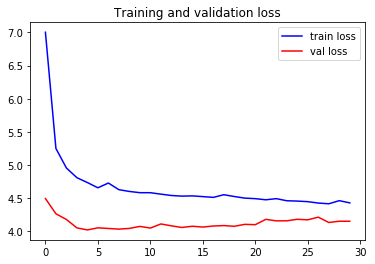

In [ ]:
def plot_training(history, from_=0):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  
  plt.plot(epochs[from_:], loss[from_:], 'b', label='train loss')
  plt.plot(epochs[from_:], val_loss[from_:], 'r', label='val loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
plot_training(history)

### Evaluation

In [ ]:
class MeanModel:
  def predict(self, X):
    return np.mean(X, axis=1)
  
class LastModel:
  def predict(self, X):
    return X[:,-1]

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  eps = 1
  return np.mean(np.abs((y_true - y_pred) / (y_true+eps))) * 100

In [ ]:
df_res = pd.DataFrame(X_train.reshape(X_train.shape[0], window_len))
df_res['real'] = y_train
df_res['predicted'] = model.predict(X_train)
df_res['baseline'] = MeanModel().predict(X_train)
df_res.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,real,predicted,baseline
646,2,1,0,0,1,1,1,1,0,5,39,26,21,13.839115,6.416667
353,22,22,9,9,16,19,6,4,5,14,29,24,18,15.455268,14.916667
3291,4,2,0,0,1,3,3,2,7,6,17,18,7,9.052274,5.250000
879,0,0,2,0,0,1,1,3,0,2,0,0,0,0.286777,0.750000
2006,19,8,4,7,2,4,3,2,1,2,2,8,1,4.081444,5.166667
2617,4,9,3,3,2,0,1,0,0,1,4,0,4,0.921925,2.250000
4230,0,2,0,0,0,0,0,0,13,11,39,18,40,10.298325,6.916667
1026,4,6,4,1,0,1,0,0,3,0,5,2,1,1.631719,2.166667
4262,5,0,1,4,0,1,5,3,2,3,0,0,2,0.879372,2.000000
2930,8,9,10,112,79,9,24,4,7,15,5,14,15,11.691222,24.666667


In [ ]:
import sklearn.metrics 
print('Baseline: {:.2f}'.format(sklearn.metrics.mean_squared_error(df_res.real, df_res.baseline)))
print('Model: {:.2f}'.format(sklearn.metrics.mean_squared_error(df_res.real, df_res.predicted)))

Baseline: 178.13
Model: 138.99


In [ ]:
df_res = pd.DataFrame(X_test.reshape(X_test.shape[0], window_len))
df_res['real'] = y_test
df_res['predicted'] = model.predict(X_test)
df_res['baseline'] = MeanModel().predict(X_test)
df_res.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,real,predicted,baseline
1009,4,5,2,4,2,3,13,8,2,4,0,4,0,2.165316,4.250000
458,0,0,0,1,1,0,0,1,1,1,0,2,0,1.124839,0.583333
99,8,22,22,9,9,16,19,6,4,5,14,29,24,17.164249,13.583333
368,0,2,3,3,0,2,6,11,3,0,3,2,6,1.916418,2.916667
10,10,9,12,16,14,7,5,3,6,5,5,8,0,5.419456,8.333333
560,5,3,2,9,6,1,2,4,3,6,12,4,6,3.350023,4.750000
888,0,0,1,0,1,0,2,1,106,11,32,2,0,12.344864,13.000000
190,1,0,0,3,4,2,0,0,0,1,2,1,1,0.940191,1.166667
328,0,5,2,1,1,0,0,2,1,1,3,0,2,0.993273,1.333333
599,0,1,0,1,1,0,0,2,0,1,1,0,3,0.417586,0.583333


In [ ]:
import sklearn.metrics 
print('Predict Zeros: {:.2f}'.format(sklearn.metrics.mean_absolute_error(df_res.real, np.zeros((len(df_res), 1)))))
print('Baseline: {:.2f}'.format(sklearn.metrics.mean_absolute_error(df_res.real, df_res.baseline)))
print('Model: {:.2f}'.format(sklearn.metrics.mean_absolute_error(df_res.real, df_res.predicted)))

Predict Zeros: 6.39
Baseline: 5.00
Model: 4.15


In [ ]:
data[5]

array([ 0,  0,  0,  6, 19,  3,  2,  1,  0,  0,  6, 16, 13, 22,  5,  3,  2,
        3,  4,  1,  0,  1,  2,  0,  3,  2,  0,  2,  5,  1,  0,  2,  3,  0,
        1,  0,  1,  1,  1,  0,  1,  3,  1,  0,  1,  0,  0,  0,  0,  7,  4,
        2,  1,  2,  2,  0,  1,  1,  0])

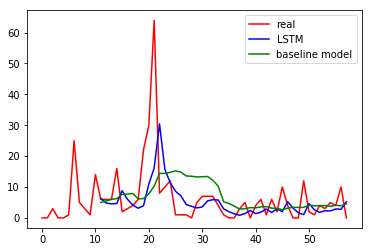

In [ ]:
artist_id = 56
plot_real = data[artist_id][:window_len-1].tolist()
plot_pred = []
plot_base = []

for i in range(window_len, data.shape[1]):
  x_obs = data[artist_id][i-window_len:i]
  y_obs = data[artist_id][i]
  y_pred = np.squeeze(model.predict(x_obs.reshape((1, window_len, 1))))
  y_pred = max(y_pred, 0)
  y_base = np.squeeze(MeanModel().predict(x_obs.reshape((1, window_len, 1))))
  y_real = y_obs
  plot_real.append(y_real)
  plot_pred.append(y_pred)
  plot_base.append(y_base)
  #print(x_obs, y_real, y_pred)


plt.plot(range(len(plot_real)), plot_real, 'r', label='real')
plt.plot(range(window_len-1, len(plot_real)), plot_pred, 'b', label='LSTM')
plt.plot(range(window_len-1, len(plot_real)), plot_base, 'g', label='baseline model')
plt.legend()